# Satellite images segmentation

The task consists of creating a neural model able to perform semantic segmentation on satellite images into six (seven with the no information) different classes. The data used in this project is extracted from the [IGN](https://geoservices.ign.fr/telechargement) archives, and can be downloaded [here](https://drive.google.com/file/d/1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem/view?usp=sharing).

Each tile in the dataset has a 1000x1000 resolution representing a 500m x 500m footprint (the resolution is 50cm per pixel).

The file structure of the dataset is as follows:
```none
├── ign
│   ├── annotations
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png
│   ├── images
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png

```

Here is an example of the image/mask contained in the dataset:
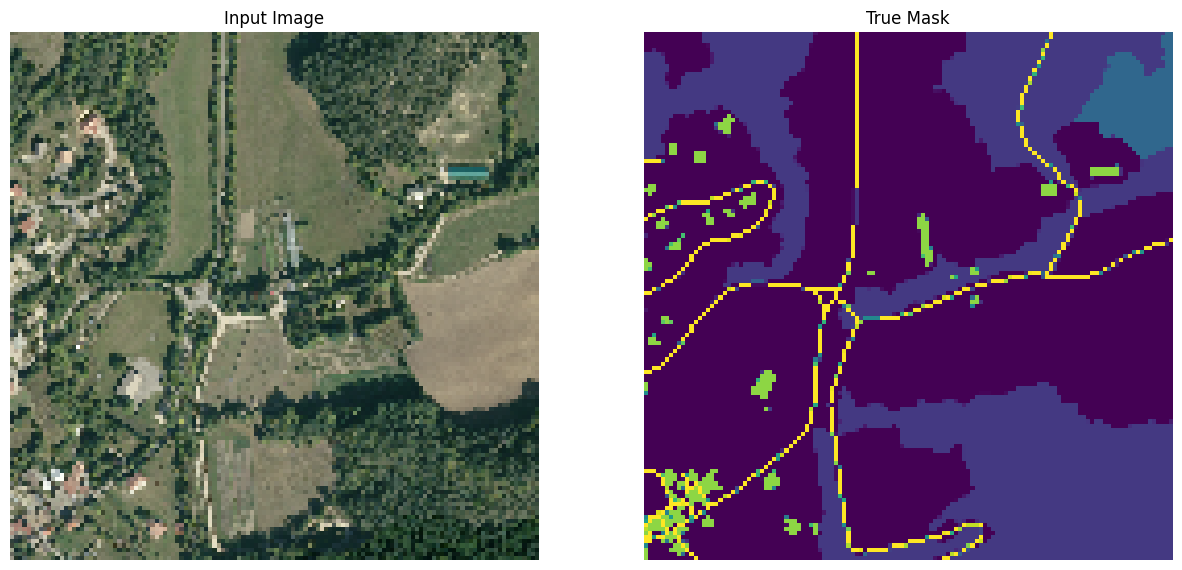

HINT: If the data does not fit into the memory, try by patching the image into smaller portions.

## Downloading the data

The data can be either downloaded from the link above and uploaded directly on Colab, or by running the following code snippet, that automatically downloads the data and unzip it.

In [ ]:
# !gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
!gdown 1_ZNbkEnMJlYJKXpjrGNS1gZeB_BrTnf2
# !gdown 1yK8ctJejIsPat9qgF10MnTI2ZnuJUyLV
!unzip ign_dataset.zip
!rm ign_dataset.zip

## Multi-class segmentation

In this project, the input-target pair is composed by a $1000 \times 1000$ RGB image as visualized above, together with a $1000 \times 1000$ mask, that classifies each pixel by assigning to it a real number.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import os


X_path = './ign/images/'
Y_path = './ign/annotations/'

train_name = sorted(os.listdir(os.path.join(X_path, 'training')))
test_name = sorted(os.listdir(os.path.join(X_path, 'validation')))

# As an example: load a sample to check the data
x_sample = plt.imread(os.path.join(X_path, 'training', train_name[10]))
y_sample = plt.imread(os.path.join(Y_path, 'training', train_name[10]))

print(f"Shape of x: {x_sample.shape}. Shape of y: {y_sample.shape}.")
print(f"Unique values of y: {np.unique(y_sample)}.")
print(f'Number of train images: {len(train_name)}')
print(f'Number of test images: {len(test_name)}')

Shape of x: (1000, 1000, 3). Shape of y: (1000, 1000).
Unique values of y: [0.         0.00392157 0.02352941].
Number of train images: 600
Number of test images: 200


In the example above, _y_sample_ contains 3 classes, represented by the three unique real numbers $[0, 0.00392157, 0.02352941]$.

Note that this approach is unusual in multiclass segmentation, where usually the mask is reshaped to be an $height \times width \times num. class$ binary array, where the pixel in position $(i, j)$ is classified as the class associated to the value 1, among the channels.

In this project, we assume that your data is processed as described above, since the metric used for the evaluation is implemented this way.  

## Metrics
The comparison metric for this project is the Dice Cofficient for multi-class segmentation (see the Lab about Segmentation for more informations). To apply this function, you are required to reshape both the predicted mask and the true mask to shape _(batch_size, h, w, num_classes)_, where _num_classes_ is the number of segmentation classes.

**IMPORTANT**: Remember to leave a print of average Dice Coefficient among the test set on the Notebook for a comparison. To do that, just measure the Dice Coffient by using the functions below for each batch, and take the average.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

## Project implementation

Good luck!

### Student: 

Sonno Davide, mat. 0001147866

In [3]:
def random_crop(image, mask, shape):
    '''
	Perform a random crop of given size
    '''
    import random
    patch_size=shape
    ph, pw = patch_size
    h, w, _ = image.shape
    start_row = random.randint(0,h-ph)
    start_col = random.randint(0,w-pw)
    end_row = start_row + ph
    end_col = start_col + pw
    return (
        image[start_row:end_row, start_col:end_col, ...],
        mask[start_row:end_row, start_col:end_col, ...]
        )

def get_random_patches(image,mask,shape,amount=0):
    '''
	Return a list of `amount` random patches of given shape
    '''
    if amount==0: # full image
        return [image],[mask]
    images=[]
    masks=[]
    for _ in range(amount):
        patch_x,patch_y=random_crop(image,mask,shape)
        images.append(patch_x)
        masks.append(patch_y)
    return images,masks

Let's start by loading the images from the dataset. I was able to use the whole images, but smaller part of the image could be used aswell, by changing the parameters of the above functions.

In [4]:
from PIL import Image


def read_train_dataset(train_names, X_path, Y_path,sub_images=0,sub_shape=None):
    x_train = []
    y_train = []
    for idx, img_name in enumerate(train_names):
        x = Image.open(os.path.join(X_path, 'training', img_name)) # by reading them with PIL we already have the class values
        y = Image.open(os.path.join(Y_path, 'training', img_name)) # 
        x=np.array(x)
        y=np.array(y)
        patches_x,patches_y=get_random_patches(x,y,sub_shape,sub_images)
        x_train=x_train+patches_x
        y_train=y_train+patches_y

        if idx%100 == 99:
            print(f"Processed {idx+1} training images.")
    print(f"Total training images processed: {idx+1}.")

    return (np.array(x_train),np.array(y_train))

HOST_SHAPE=(1000,1000) # the crop of the original image to use for augmentation


x_train,y_train=read_train_dataset(train_name,X_path,Y_path,sub_shape=HOST_SHAPE)
print(x_train.shape,y_train.shape)

Processed 100 training images.
Processed 200 training images.
Processed 300 training images.
Processed 400 training images.
Processed 500 training images.
Processed 600 training images.
Total training images processed: 600.
(600, 1000, 1000, 3) (600, 1000, 1000)


## Weighting the classes

Before going further we create a dictionary of weights for the classes. This is to make the model learn to give more importance to less frequent classes classes. We are doing this because the DICE score performs an average along the classes, so we should try to maximize the score for each class, namely on the less represented classes that are harder for th emodel to learn.

Different metrics were tested but the best one found is the one returned in the case 3 of the following switch.

In [6]:
def compute_class_weights(masks, type=1):
    unique_classes, counts = np.unique(masks, return_counts=True)
    print(unique_classes,counts)

    match(type): # change weighting method accordingly
        case 1:
            counts = len(masks)/(len(unique_classes)*counts)
        case 2:
            total=np.sum(counts)
            counts=(total-counts)/total
        case 3:
            import math
            mu=0.15
            total=np.sum(counts)
            counts=[2*math.log(mu*total/float(counts[i])) for i in range(len(unique_classes))]
            counts=[count if count>1.0 else 1.0 for count in counts]
        case _: pass

    weights_dict = {class_: weight for class_, weight in zip(unique_classes, counts)}

    return weights_dict

In [7]:
CLASS_WEIGHTS=compute_class_weights(y_train,3)
print(CLASS_WEIGHTS)

[0 1 2 3 4 5 6] [ 68597879 368973792  69776006  41415145  41344610    918376   8974192]
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.5523260702784782, 4: 1.555735216044011, 5: 9.169916112985478, 6: 4.6109135357276525}


### Loss

After computing the class weights, we also define a loss function to use along the class weights.

 Unfortunately I was using `sparse_categorical_crossentropy`, but the native parameter for class_weights inside the `fit` method of the model is not compatible when the ground truth has more than 2 dimensions, and that is our case since that $y$ has shape $batch\_size\times 256\times 256$.

 That being said I had to implement the loss above and also considering the weights of each class.

In [8]:
CLASS_WEIGHTS = tf.constant([CLASS_WEIGHTS[i] for i in range(len(CLASS_WEIGHTS))], dtype=tf.float32)

def sparse_categorical_crossentropy_with_weights(y_true, y_pred):
    '''
	Uses `tf.keras.losses.sparse_categorical_crossentropy` while also weighting the classes.
    '''
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(CLASS_WEIGHTS)) # encode the mask
    weights = tf.reduce_sum(CLASS_WEIGHTS * y_true_oh, axis=-1)
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred) # categorical loss
    weighted_loss = unweighted_loss * weights # weight the loss
    return tf.reduce_mean(weighted_loss)

## Augmentation

The most important phase is the augmentation. The dataset is too small to provide meaningful information.

The following augmentation are used:
- $90^\circ$, $180^\circ$ and $270^\circ$(so $-90^\circ$) rotations
- the flipped version of the previous rotations

_Color augmentations were tested but did not provide interesting results._

In [5]:
def augment_image(image, mask):
    mask = tf.expand_dims(mask, axis=-1)

    geom_augm = [
        lambda img, msk: (img, msk),
        lambda img, msk: (tf.image.rot90(img, k=1), tf.image.rot90(msk, k=1)),
        lambda img, msk: (tf.image.rot90(img, k=2), tf.image.rot90(msk, k=2)),
        lambda img, msk: (tf.image.rot90(img, k=3), tf.image.rot90(msk, k=3)),
        lambda img, msk: (tf.image.flip_left_right(img), tf.image.flip_left_right(msk)),
        lambda img, msk: (tf.image.rot90(tf.image.flip_left_right(img), k=1), tf.image.rot90(tf.image.flip_left_right(msk), k=1)),
        lambda img, msk: (tf.image.rot90(tf.image.flip_left_right(img), k=2), tf.image.rot90(tf.image.flip_left_right(msk), k=2)),
        lambda img, msk: (tf.image.rot90(tf.image.flip_left_right(img), k=3), tf.image.rot90(tf.image.flip_left_right(msk), k=3)),
    ]
    aug_func = np.random.choice(geom_augm)
    image,mask=aug_func(image, mask)
    mask=tf.squeeze(mask, axis=-1)
    return image,mask

def augment_batches(images,masks,factor,sub_shape):
    '''
	Given a batch if images, produces `factor` images from each element of the batch,
    by randomly cropping it with shape `sub_shape` and performing augmentation.
    '''
    augm_images=[]
    augm_masks=[]
    for image,mask in zip(images,masks):
        for _ in range(factor):
            img,msk=random_crop(image,mask,sub_shape)
            img,msk=augment_image(img,msk)
            augm_images.append(img)
            augm_masks.append(msk)
    augm_images=np.array(augm_images)
    augm_masks=np.array(augm_masks)
    return augm_images,augm_masks

To overcome this problem, augmentation is used to create more train samples. I decided to create a Sequence to be able to augment the images __BEFORE__ each epoch and not only once before the training. To do so The object saves the original images, and at the end of each epoch new images are generated. This behaviour can be set by the user using `augmentions_interval:int=...`

_I tried using Tensorflow's Dataset but I did not manage to find a way to perform the augmentation over and over, also they are not so user-friendly..._

In [6]:
class Augmenter(tf.keras.utils.Sequence):

    def __init__(self, x_in, y_in,sub_amount, sub_shape, batch_size, shuffle=True,augmentions_interval=None,name='Augmenter'):
        self.x_original=x_in                    # starting images to perform augmentation from
        self.y_original=y_in                    # starting masks to perform augmentation from
        self.sub_amount=sub_amount              # number of augmentations for each original image
        self.sub_shape=sub_shape                # shape of the augmented images
        self.batch_size = batch_size            # number of images returned when accessing the Augmenter (e.g. the batch used by the model)
        self.augmented_x=self.augmented_y=None
        self.datalen = len(self.x_original)*self.sub_amount
                                                # total number of test images, so the number of augmented images
        self.indexes = np.arange(self.datalen)  # instead of shuffling the arrays, shuffle the indexes to acces them
        self.shuffle = shuffle                  # decide if shuffling indexes
        if self.shuffle:
            np.random.shuffle(self.indexes)     # shuffle the indexes
        self.aug_int=augmentions_interval       # amount of epoch to pass before augmenting new images
        self.internal_count=0
        self.name=name                          # name of the Augmenter

    def __getitem__(self, index):
        '''
        Returns the batch at index given
        '''
        try:
            batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
            x_batch = self.augmented_x[batch_indexes]
            y_batch = self.augmented_y[batch_indexes]
            return x_batch,y_batch
        except TypeError: # this happens when accessing the data before an epoch or in general before augmenting for the first time
            idxs=np.random.choice(len(self.x_original),self.batch_size//self.sub_amount,replace=False)
            return augment_batches(
                self.x_original[idxs],
                self.y_original[idxs],
                self.sub_amount,
                self.sub_shape
            )

    def __len__(self):
        '''
        Returns the total number of batches in the Augmenter.
        '''
        return self.datalen // self.batch_size

    def on_epoch_begin(self):
        '''
	    If an `augmentation_interval` is set, augment according to it.
        If `shuffle`, shuffle the Sequence.
        '''
        self.internal_count+=1
        if self.internal_count%self.aug_int==0:
            self.augmented_x=self.augmented_y=None # avoid filling the memory
            self.augmented_x,self.augmented_y=augment_batches(self.x_original,self.y_original,self.sub_amount,self.sub_shape)
            print(f'\n{self.name}: Images augmented')
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

## Train and Validation data

Let's finally prepare the Sequences that we are going to pass to the model in the training phase, both for the training and validation set.

_We can't use the native split inside the `model.fit` beacuse it is not compatible with Sequences or Datasets._

In [7]:
from sklearn.model_selection import train_test_split


VAL_SPLIT = 0.2
SHAPE=(256,256)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT, random_state=42)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(480, 1000, 1000, 3) (480, 1000, 1000) (120, 1000, 1000, 3) (120, 1000, 1000)


In [8]:
def clean_memory(*elements):
    '''
	Due to the limitations in memory we have to clean up some used variables.
    '''
    for e in elements:
        del e


SHAPE=(256,256)
BATCH_SIZE=32
SUBS=16

train_augm=Augmenter(x_train,y_train,SUBS,SHAPE,BATCH_SIZE,augmentions_interval=1,name='Train_augm')
clean_memory(x_train,y_train)
val_augm=Augmenter(x_val,y_val,SUBS,SHAPE,BATCH_SIZE,name='Val_augm') # we do not augment the validation nset after each epoch
clean_memory(x_val,y_val)

Another nice feature of using a `Sequence` over `tf.data.Dataset` is the easy way to access the data, simply by using the square brackets:

(32, 256, 256, 3) (32, 256, 256)


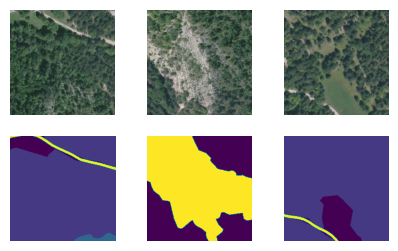

In [48]:
# print(len(train_augm)) # number of batches
# train_augm.on_epoch_begin() # augment images every augmention interval
# batch_x,batch_y = train_augm[0]
batch_x,batch_y = random.choice(train_augm)
print(batch_x.shape,batch_y.shape)
plt.figure(figsize=(5,3))
num=3
for i in range(num):
    plt.subplot(2, num, i+1)
    plt.imshow(batch_x[i].astype('uint8'))
    plt.axis('off')
    plt.subplot(2, num,num+ i+1)
    plt.imshow(batch_y[i].astype('uint8'))
    plt.axis('off')

## The Model

The model used is a simple UNet, with no particular features.

A bunch of design choices were tested:
- Batch Norm
- ReLU activation before/after the Batch Norm
- Various dropout rates. No relevant results
- Different number of convolutions for each stage, in particular for the bottleneck layer
- The kernel size of the last convolution

The output of the net is of shape $batch\_size\times 256\times 256\times num\_classes$. By using this output we can use the categorical loss, without having to worry about the different mask shape.

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation

def unet(num_classes,input_shape):
    if len(input_shape)==2:
        input_shape=input_shape+(3,)
    inputs=Input(shape=input_shape,name='input')
    params={
        'kernel_size':3,
        'padding':'same'
    }

    # down path
    conv1 = Conv2D(32, **params, name='conv11')(inputs)
    conv1 = BatchNormalization(name='batchnorm11')(conv1)
    conv1 = Activation('relu', name='activation11')(conv1)
    conv1 = Conv2D(32, **params, name='conv12')(conv1)
    conv1 = BatchNormalization(name='batchnorm12')(conv1)
    conv1 = Activation('relu', name='activation12')(conv1)
    mpool1 = MaxPooling2D(pool_size=(2, 2), name='maxpool1')(conv1)

    conv2 = Conv2D(64, **params, name='conv21')(mpool1)
    conv2 = BatchNormalization(name='batchnorm21')(conv2)
    conv2 = Activation('relu', name='activation21')(conv2)
    conv2 = Conv2D(64, **params, name='conv22')(conv2)
    conv2 = BatchNormalization(name='batchnorm22')(conv2)
    conv2 = Activation('relu', name='activation22')(conv2)
    mpool2 = MaxPooling2D(pool_size=(2, 2), name='maxpool2')(conv2)

    conv3 = Conv2D(128, **params, name='conv31')(mpool2)
    conv3 = BatchNormalization(name='batchnorm31')(conv3)
    conv3 = Activation('relu', name='activation31')(conv3)
    conv3 = Conv2D(128, **params, name='conv32')(conv3)
    conv3 = BatchNormalization(name='batchnorm32')(conv3)
    conv3 = Activation('relu', name='activation32')(conv3)
    mpool3 = MaxPooling2D(pool_size=(2, 2), name='maxpool3')(conv3)

    conv4 = Conv2D(256, **params, name='conv41')(mpool3)
    conv4 = BatchNormalization(name='batchnorm41')(conv4)
    conv4 = Activation('relu', name='activation41')(conv4)
    conv4 = Conv2D(256, **params, name='conv42')(conv4)
    conv4 = BatchNormalization(name='batchnorm42')(conv4)
    conv4 = Activation('relu', name='activation42')(conv4)
    mpool4 = MaxPooling2D(pool_size=(2, 2), name='maxpool4')(conv4)

    # bottleneck
    conv5 = Conv2D(512, **params, name='conv51')(mpool4)
    conv5 = BatchNormalization(name='batchnorm51')(conv5)
    conv5 = Activation('relu', name='activation51')(conv5)
    conv5 = Conv2D(512, **params, name='conv52')(conv5)
    conv5 = BatchNormalization(name='batchnorm52')(conv5)
    conv5 = Activation('relu', name='activation52')(conv5)
    conv5 = Conv2D(512, **params, name='conv53')(conv5)
    conv5 = BatchNormalization(name='batchnorm53')(conv5)
    conv5 = Activation('relu', name='activation53')(conv5)

    # up path
    up6 = UpSampling2D(size=(2, 2), name='upsample6')(conv5)
    reduced6 = Conv2D(128, 1, padding='same', activation='relu', name='reduce6')(up6)
    concat6 = Concatenate(name='concat6')([reduced6, conv4])
    conv6 = Conv2D(256, **params, name='conv61')(concat6)
    conv6 = BatchNormalization(name='batchnorm61')(conv6)
    conv6 = Activation('relu', name='activation61')(conv6)
    conv6 = Conv2D(256, **params, name='conv62')(conv6)
    conv6 = BatchNormalization(name='batchnorm62')(conv6)
    conv6 = Activation('relu', name='activation62')(conv6)

    up7 = UpSampling2D(size=(2, 2), name='upsample7')(conv6)
    concat7 = Concatenate(name='concat7')([up7, conv3])
    conv7 = Conv2D(128, **params, name='conv71')(concat7)
    conv7 = BatchNormalization(name='batchnorm71')(conv7)
    conv7 = Activation('relu', name='activation71')(conv7)
    conv7 = Conv2D(128, **params, name='conv72')(conv7)
    conv7 = BatchNormalization(name='batchnorm72')(conv7)
    conv7 = Activation('relu', name='activation72')(conv7)

    up8 = UpSampling2D(size=(2, 2), name='upsample8')(conv7)
    concat8 = Concatenate(name='concat8')([up8, conv2])
    conv8 = Conv2D(64, **params, name='conv81')(concat8)
    conv8 = BatchNormalization(name='batchnorm81')(conv8)
    conv8 = Activation('relu', name='activation81')(conv8)
    conv8 = Conv2D(64, **params, name='conv82')(conv8)
    conv8 = BatchNormalization(name='batchnorm82')(conv8)
    conv8 = Activation('relu', name='activation82')(conv8)

    up9 = UpSampling2D(size=(2, 2), name='upsample9')(conv8)
    concat9 = Concatenate(name='concat9')([up9, conv1])
    conv9 = Conv2D(32, **params, name='conv91')(concat9)
    conv9 = BatchNormalization(name='batchnorm91')(conv9)
    conv9 = Activation('relu', name='activation91')(conv9)
    conv9 = Conv2D(32, **params, name='conv92')(conv9)
    conv9 = BatchNormalization(name='batchnorm92')(conv9)
    conv9 = Activation('relu', name='activation92')(conv9)

    outputs = Conv2D(num_classes, 1 , 1, activation="softmax")(conv9)

    model = Model(inputs=inputs, outputs=outputs, name='unet')

    return model

In [5]:
NUM_CLASSES=7


net=unet(NUM_CLASSES,SHAPE) # the same SHAPE used earlier to tell the Augmenter the size of wich images has to be generated
net.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11 (Conv2D)                (None, 256, 256, 32  896         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batchnorm11 (BatchNormalizatio  (None, 256, 256, 32  128        ['conv11[0][0]']                 
 n)                             )                                                              

Weight decay, using `AdamW`: performed better than `Adam`.

In [27]:
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf


if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')


EPOCHS = 20
LEARNING_RATE = 1e-3
weight_dir=f"./model_weights"
save_path=os.path.join(weight_dir,"256x256.weights_") # save the weights after each epoch to be able to eventually select them

net.compile(
    optimizer=AdamW(LEARNING_RATE, weight_decay=1e-5),
    loss=sparse_categorical_crossentropy_with_weights,
    metrics=["accuracy"],
)

TensorFlow is using GPU/TPU


## Train

### Callbacks

I defined a callback to plot, after each epoch, 3 sample predictions from the Augmenter. They are drawed from the train set before the epochs and won't be updated druing the training, so there might be duplicate plots.

__Learning rate scheduler__ was used to automatically decrease the $lr$ on plateau.

In [17]:
import random
import keras

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None, print_batch=None):
        self.epoch_interval = epoch_interval
        self.print_batch=print_batch # the batch used to plot

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and (epoch) % self.epoch_interval == 0:
            try:
                self.model.save_weights(save_path+f'{epoch}.h5')
            except:
                from pathlib import Path
                if not Path(weight_dir).exists():
                    os.mkdir(weight_dir)
                self.model.save_weights(save_path+f'{epoch}.h5')
                # try:
                #     from google.colab import files
                #     files.download(save_path+f'{epoch}.h5')
                # except: pass
            if self.print_batch:
                random_x,random_y=self.print_batch
                pred_masks = self.model.predict(random_x,batch_size=BATCH_SIZE)

                random_index = random.randint(0, BATCH_SIZE - 3)
                random_preds = pred_masks[random_index:random_index+3]
                random_preds = tf.math.argmax(random_preds, axis=-1)
                random_preds = random_preds[..., tf.newaxis]

                random_images = random_x[random_index:random_index+3]
                random_true_mask = random_y[random_index:random_index+3]

                plt.figure(figsize=(20,2))
                for i in range(3):
                    plt.subplot(1,9,i*3+1)
                    plt.imshow(random_images[i])
                    plt.title(f"Image")
                    plt.subplot(1,9,i*3+2)
                    plt.imshow(random_true_mask[i])
                    plt.title(f"Ground Truth Mask")
                    plt.subplot(1,9,i*3+3)
                    plt.imshow(random_preds[i])
                    plt.title(f"Predicted Mask")
                plt.show()
                plt.close()


class AugmenterCallback(keras.callbacks.Callback):
    def __init__(self,method):
        self.augmenter_method=method

    def on_epoch_begin(self,epoch,logs):
        self.augmenter_method()


In [18]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

random_train_batch=random.choice(train_augm) # the batch from were to print the random predictions

callbacks = [
    AugmenterCallback(train_augm.on_epoch_begin), # Augmenter.on_epoch_begin() does not get called automatically
    DisplayCallback(1,random_train_batch),
    lr_scheduler
]


Train_augm: Images augmented
Epoch 1/20
  6/240 [..............................] - ETA: 2:48 - loss: 1.8892 - accuracy: 0.4849

1/1 [==============================] - 0s 401ms/step


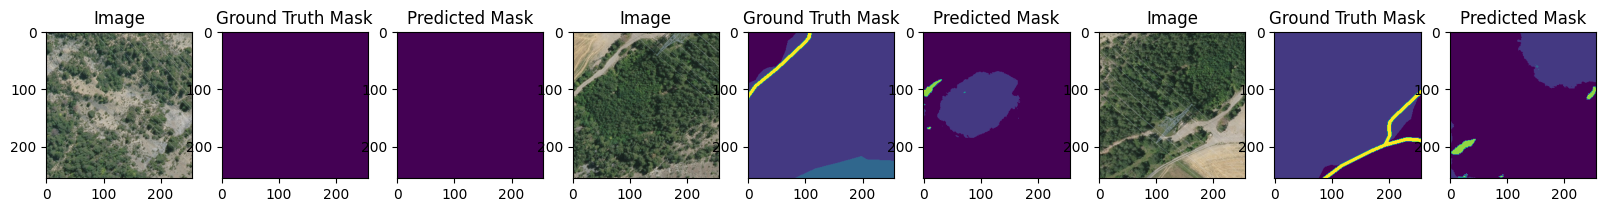

240/240 [==============================] - 245s 835ms/step - loss: 1.1640 - accuracy: 0.6884 - val_loss: 7.0870 - val_accuracy: 0.2040 - lr: 0.0010

Train_augm: Images augmented
Epoch 2/20
1/1 [==============================] - 0s 26ms/step


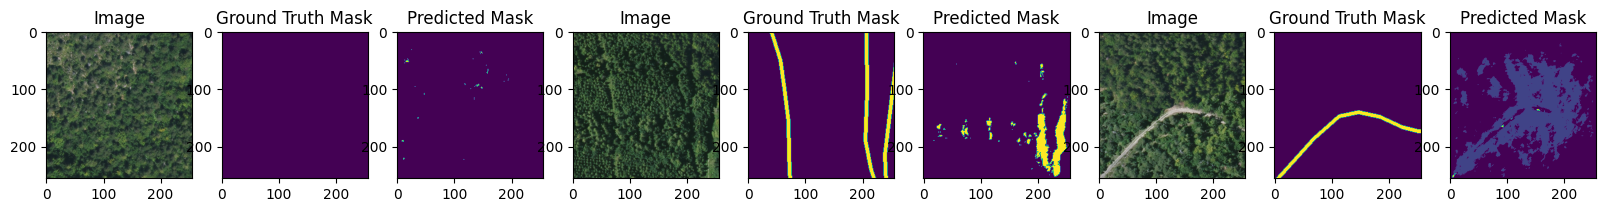

240/240 [==============================] - 201s 837ms/step - loss: 1.0107 - accuracy: 0.7200 - val_loss: 1.6751 - val_accuracy: 0.6746 - lr: 0.0010

Train_augm: Images augmented
Epoch 3/20
1/1 [==============================] - 0s 35ms/step


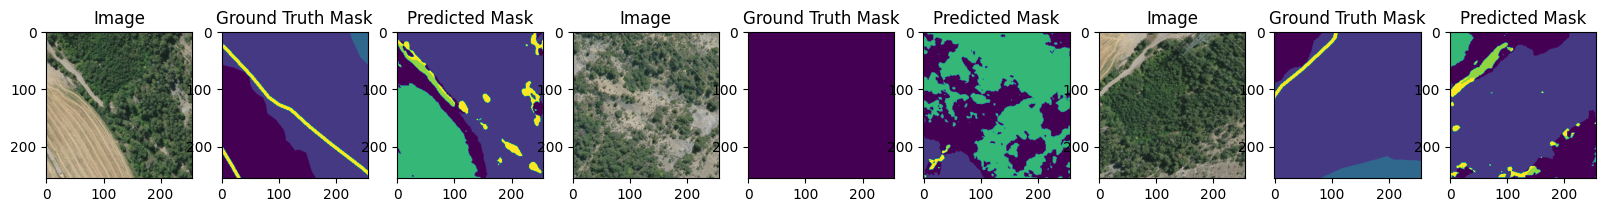

240/240 [==============================] - 218s 907ms/step - loss: 0.9440 - accuracy: 0.7461 - val_loss: 1.6205 - val_accuracy: 0.6367 - lr: 0.0010

Train_augm: Images augmented
Epoch 4/20
1/1 [==============================] - 0s 25ms/step


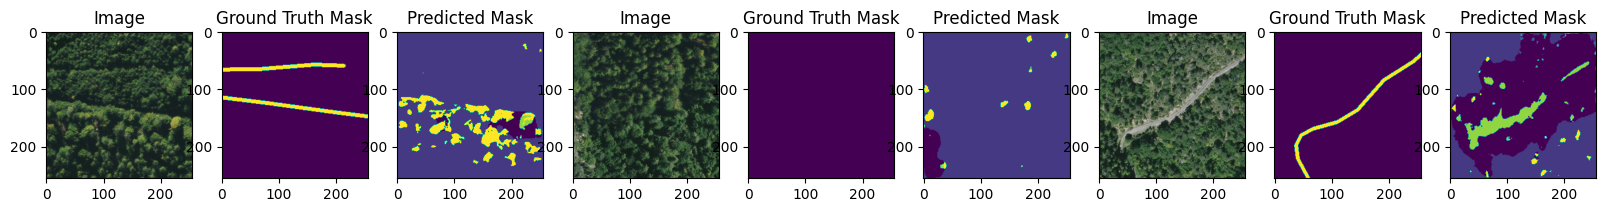

240/240 [==============================] - 198s 827ms/step - loss: 0.9131 - accuracy: 0.7530 - val_loss: 3.0531 - val_accuracy: 0.3338 - lr: 0.0010

Train_augm: Images augmented
Epoch 5/20
1/1 [==============================] - 0s 22ms/step


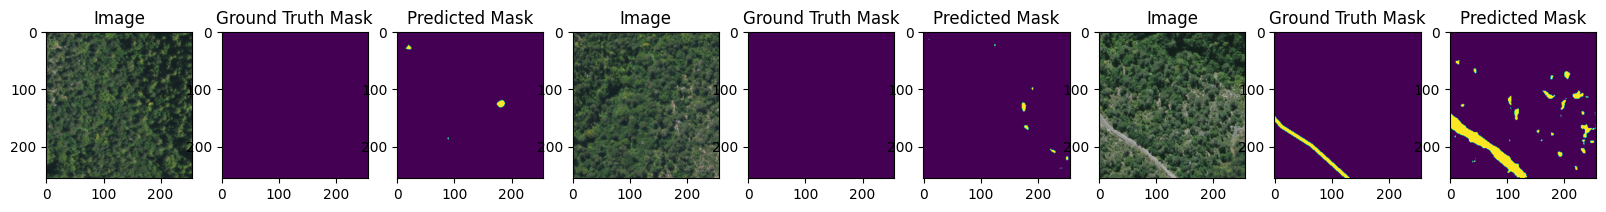

240/240 [==============================] - 199s 829ms/step - loss: 0.8935 - accuracy: 0.7577 - val_loss: 3.3636 - val_accuracy: 0.4407 - lr: 0.0010

Train_augm: Images augmented
Epoch 6/20
1/1 [==============================] - 0s 24ms/step


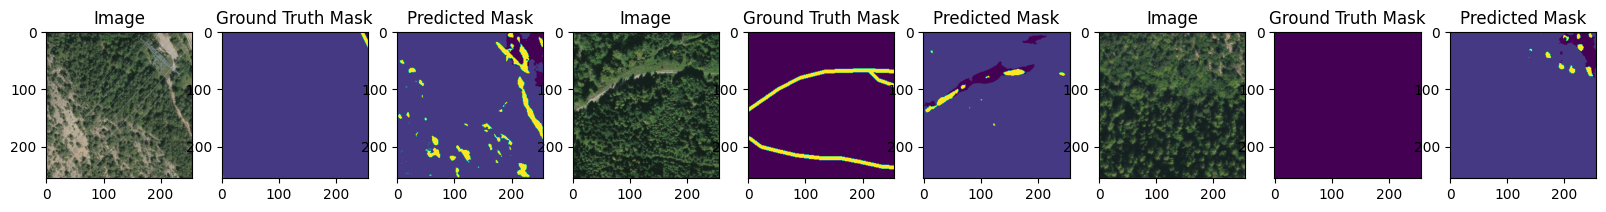

240/240 [==============================] - 198s 826ms/step - loss: 0.8593 - accuracy: 0.7706 - val_loss: 1.3846 - val_accuracy: 0.6404 - lr: 0.0010

Train_augm: Images augmented
Epoch 7/20
1/1 [==============================] - 0s 23ms/step


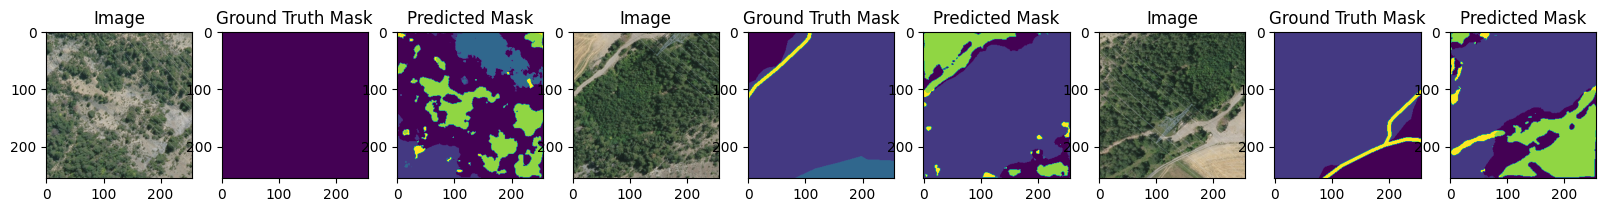

240/240 [==============================] - 198s 824ms/step - loss: 0.8367 - accuracy: 0.7768 - val_loss: 2.0723 - val_accuracy: 0.5767 - lr: 0.0010

Train_augm: Images augmented
Epoch 8/20
1/1 [==============================] - 0s 44ms/step


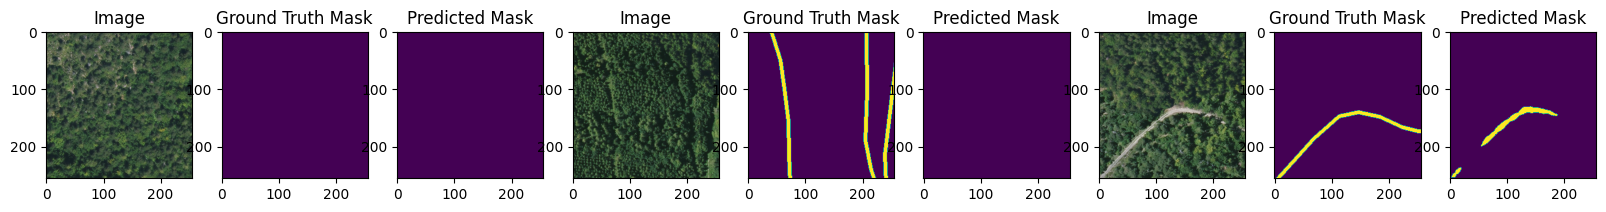

240/240 [==============================] - 200s 832ms/step - loss: 0.8210 - accuracy: 0.7809 - val_loss: 0.9087 - val_accuracy: 0.7663 - lr: 0.0010

Train_augm: Images augmented
Epoch 9/20
1/1 [==============================] - 0s 23ms/step


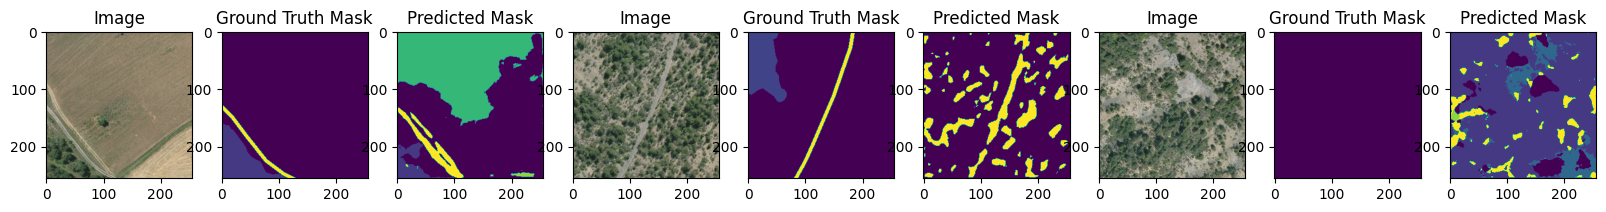

240/240 [==============================] - 199s 830ms/step - loss: 0.8078 - accuracy: 0.7823 - val_loss: 1.2392 - val_accuracy: 0.6728 - lr: 0.0010

Train_augm: Images augmented
Epoch 10/20
1/1 [==============================] - 0s 22ms/step


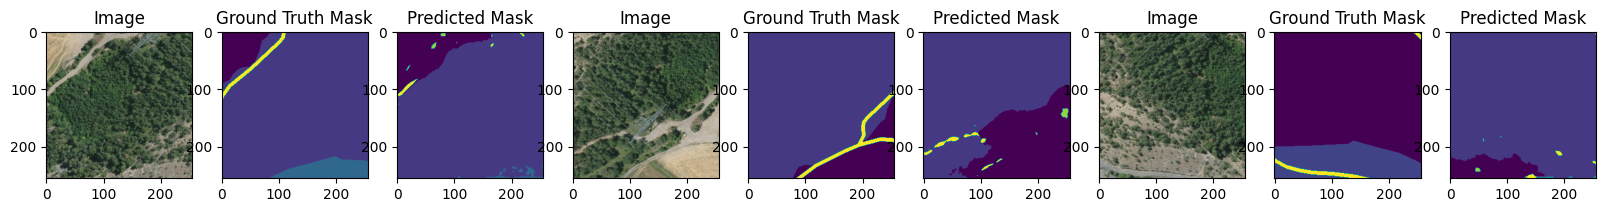

240/240 [==============================] - 198s 825ms/step - loss: 0.7989 - accuracy: 0.7818 - val_loss: 1.4486 - val_accuracy: 0.6802 - lr: 0.0010

Train_augm: Images augmented
Epoch 11/20
1/1 [==============================] - 0s 23ms/step


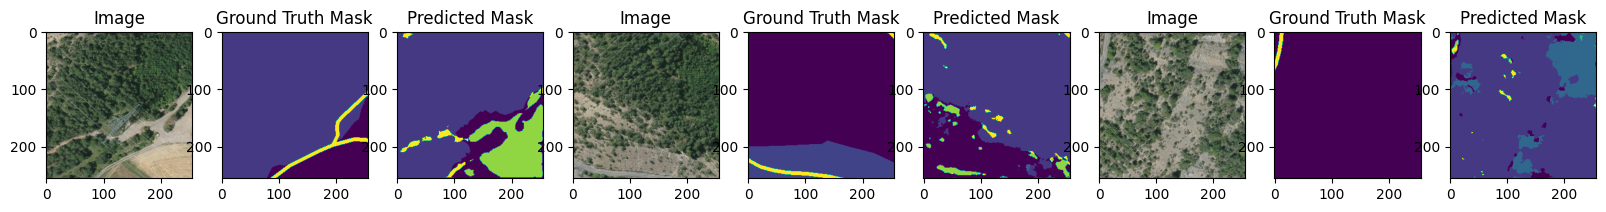

240/240 [==============================] - 200s 834ms/step - loss: 0.7690 - accuracy: 0.7941 - val_loss: 1.2153 - val_accuracy: 0.6685 - lr: 0.0010

Train_augm: Images augmented
Epoch 12/20
1/1 [==============================] - 0s 23ms/step


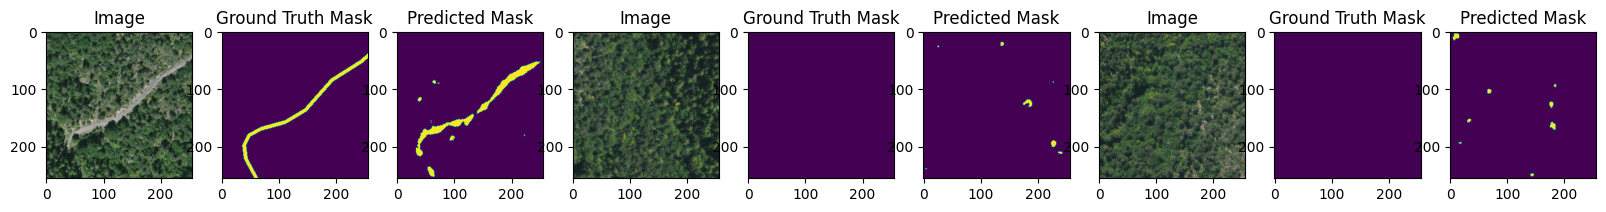


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
240/240 [==============================] - 200s 836ms/step - loss: 0.7708 - accuracy: 0.7920 - val_loss: 0.9408 - val_accuracy: 0.7688 - lr: 0.0010

Train_augm: Images augmented
Epoch 13/20
1/1 [==============================] - 0s 22ms/step


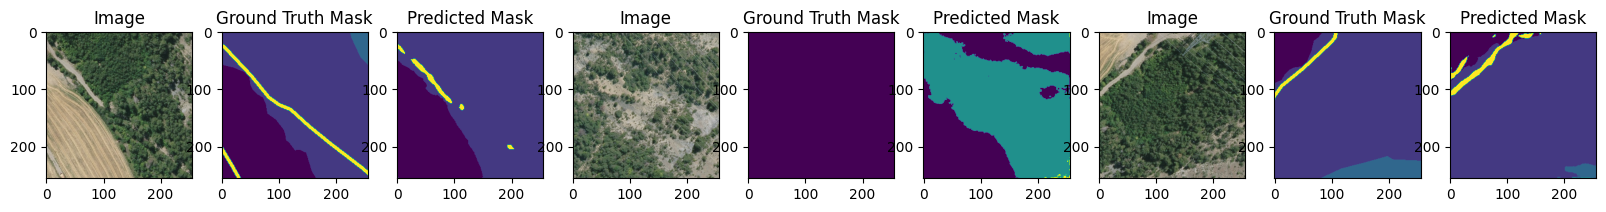

240/240 [==============================] - 200s 832ms/step - loss: 0.7152 - accuracy: 0.8108 - val_loss: 0.7272 - val_accuracy: 0.8030 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 14/20
1/1 [==============================] - 0s 23ms/step


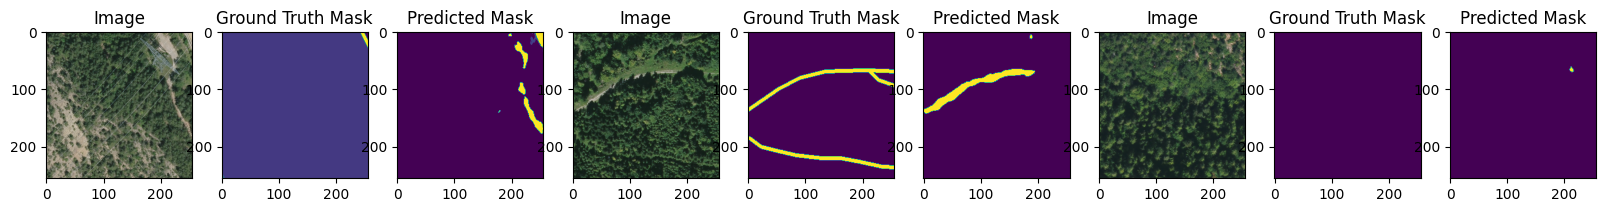

240/240 [==============================] - 201s 836ms/step - loss: 0.7080 - accuracy: 0.8114 - val_loss: 0.6861 - val_accuracy: 0.8281 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 15/20
1/1 [==============================] - 0s 23ms/step


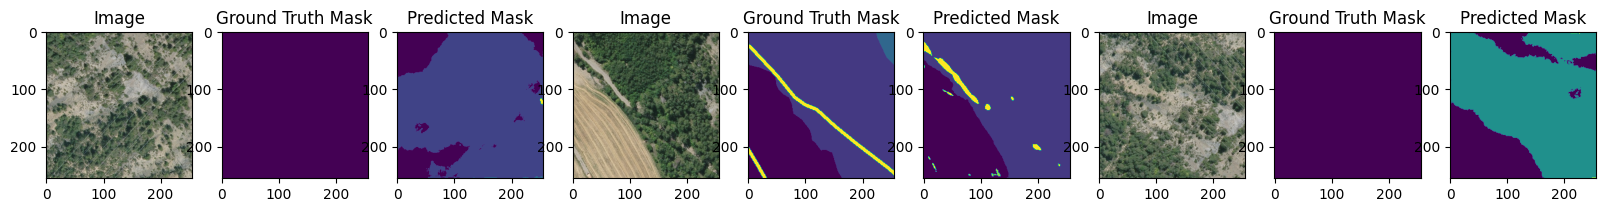

240/240 [==============================] - 200s 834ms/step - loss: 0.7054 - accuracy: 0.8106 - val_loss: 0.6912 - val_accuracy: 0.8302 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 16/20
1/1 [==============================] - 0s 24ms/step


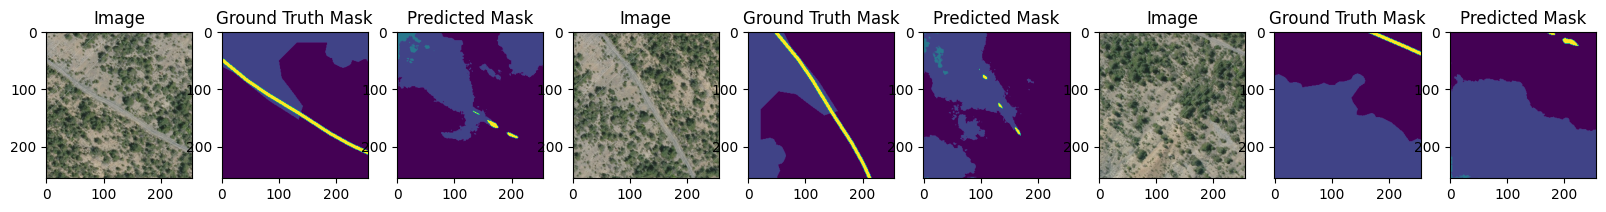

240/240 [==============================] - 198s 824ms/step - loss: 0.7055 - accuracy: 0.8113 - val_loss: 0.7543 - val_accuracy: 0.8160 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 17/20
1/1 [==============================] - 0s 22ms/step


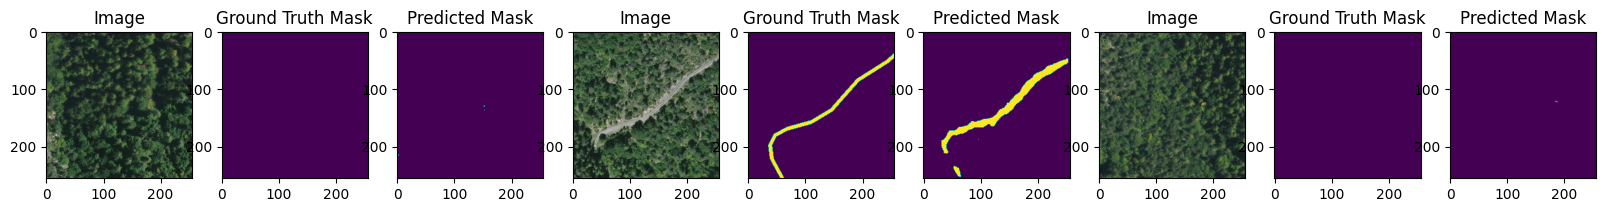

240/240 [==============================] - 199s 830ms/step - loss: 0.6888 - accuracy: 0.8151 - val_loss: 0.6747 - val_accuracy: 0.8336 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 18/20
1/1 [==============================] - 0s 47ms/step


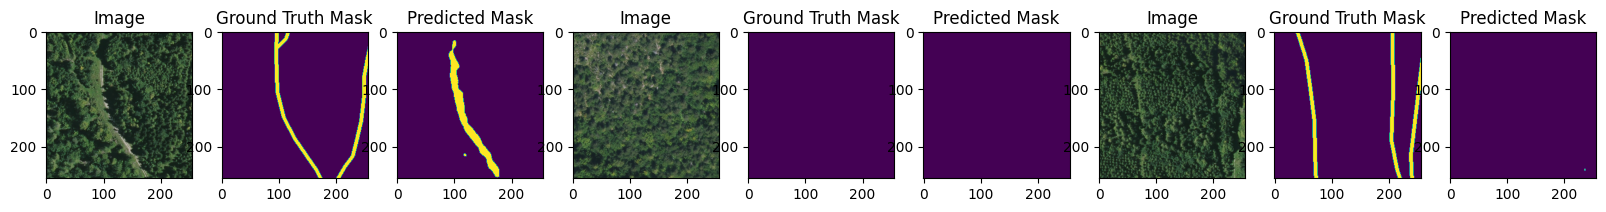

240/240 [==============================] - 201s 836ms/step - loss: 0.6933 - accuracy: 0.8146 - val_loss: 0.6998 - val_accuracy: 0.8245 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 19/20
1/1 [==============================] - 0s 25ms/step


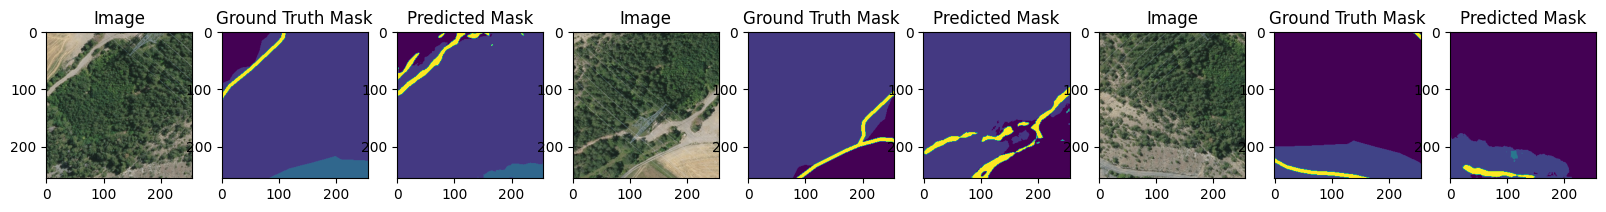

240/240 [==============================] - 200s 834ms/step - loss: 0.6887 - accuracy: 0.8151 - val_loss: 0.8036 - val_accuracy: 0.7929 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 20/20
1/1 [==============================] - 0s 24ms/step


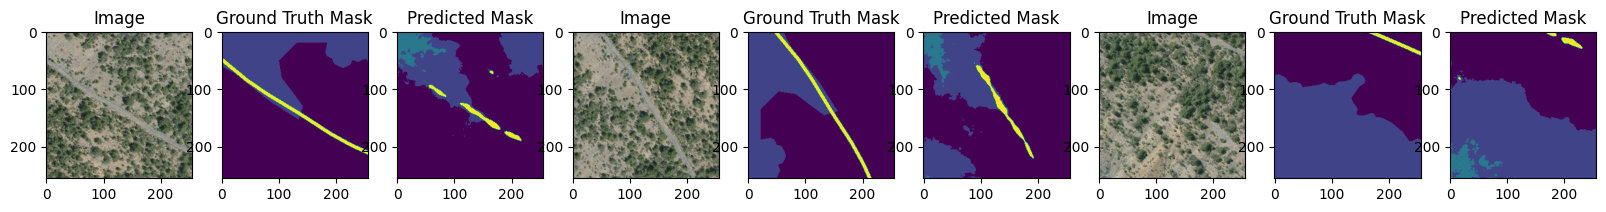

240/240 [==============================] - 201s 839ms/step - loss: 0.6913 - accuracy: 0.8171 - val_loss: 0.7575 - val_accuracy: 0.8082 - lr: 1.0000e-04


In [ ]:
history = net.fit(
    x=train_augm,
    epochs=EPOCHS,
    validation_data=val_augm,
    callbacks=callbacks,
)

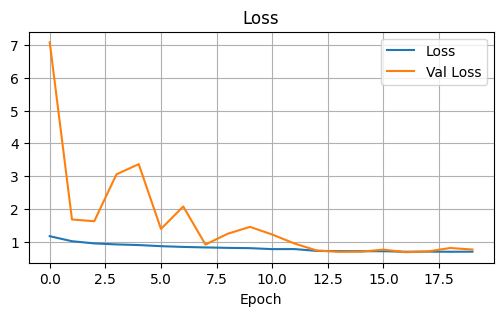

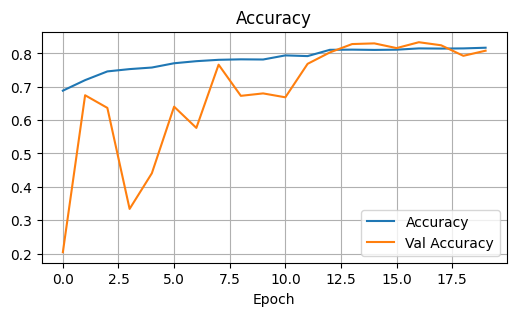

In [ ]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(6,3))
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

## Test

For the test set the whole images are divided into a grid so that each sub image has shape the same input shape as the model and the whole image is tested. In this case $1000\times 1000$ images are split into a grid of 16 images of size $256\times 256$

In [6]:
def split_sub_images(image, amount):
    '''
	Split the image in a grid.
    '''
    if amount not in [4, 16, 64]:
        raise ValueError(f'Unsupported amount: {amount}')
    h, w = image.shape[:2]
    def next_power_of_2(n):
        if n < 1:
            return 1
        if (n & (n - 1)) == 0:
            return n
        power = 1
        while power < n:
            power <<= 1
        return power
    size = next_power_of_2(h // 2)
    if image.ndim == 3:  # x
        sub_images = [
            image[:size, :size, :],
            image[:size, w-size:, :],
            image[h-size:, :size, :],
            image[h-size:, w-size:, :],
        ]
    else:  # y
        sub_images = [
            image[:size, :size],
            image[:size, w-size:],
            image[h-size:, :size],
            image[h-size:, w-size:],
        ]
    if amount == 16:
        sub_images = [sub for img in sub_images for sub in split_sub_images(img, 4)]
    if amount == 64:
        sub_images = [sub for img in sub_images for sub in split_sub_images(img, 16)]
    return sub_images

Load the test images (it was not did earlier cause of, again, memory related issues).

In [7]:
def read_test_dataset(test_names, X_path, Y_path,sub_images=16):
    from PIL import Image
    x_test = []
    y_test = []
    for idx, img_name in enumerate(test_names):
        x = Image.open(os.path.join(X_path, 'validation', img_name))
        x=np.array(x)
        x_test=x_test+split_sub_images(x,sub_images)
        y = Image.open(os.path.join(Y_path, 'validation', img_name))
        y=np.array(y)
        y_test=y_test+split_sub_images(y,sub_images)

        if idx%100 == 99:
            print(f"Processed {idx+1} test images.")
    print(f"Total test images processed: {idx+1}.")
    return (np.array(x_test), np.array(y_test))

x_test_img,y_test_img=read_test_dataset(test_name,X_path,Y_path)
print(x_test_img.shape,y_test_img.shape) # 200 x 16 images = 200 original images divided in a 4x4 grid 

Processed 100 test images.
Processed 200 test images.
Total test images processed: 200.
(3200, 256, 256, 3) (3200, 256, 256)


Since that using different batch sizes provides different DICE scores, I decided to compute it for single images as it should be defined as a per-image score.

In [8]:
def evaluate_model(model,x_test,y_test,batch_size,num_classes,metric,interval=10):
    len_images=len(x_test)
    avg_dice = 0.0
    print(f'total images on the test set: {len_images}')
    print('======================================')
    for i in range(len_images//batch_size):
        i*=batch_size
        pred_masks = model.predict(x_test[i:i+batch_size,:,:],verbose=0)
        one_hot_encoded_pred = np.eye(num_classes)[tf.math.argmax(pred_masks, axis=-1)]
        one_hot_encoded_true = np.eye(num_classes)[y_test[i:i+batch_size,:,:]]
        batch_score=0
        for true,pred in zip(one_hot_encoded_true, one_hot_encoded_pred): # for each image of the batch compute the score
            batch_score+=metric(np.expand_dims(true,axis=0),np.expand_dims(pred,axis=0), num_classes)
        batch_score/=batch_size
        avg_dice += batch_score
        i=i//batch_size
        if (i+1)%interval==0:
            print(f'Batch {i+1}/{len_images//batch_size} score: {batch_score:.5f}')
            print(f'Running average: {avg_dice/(i+1)}')
    avg_dice /= (len_images//batch_size)
    print('======================================')
    print(f'Final test set score: {avg_dice:.5f}')
    print('======================================')

We inspect the current DICE. After some tests the weights obtained from the 18th epoch worked better.

In [28]:
try:
    net.load_weights(save_path+f'17.h5')
    print(f'Weights loaded ({save_path}17.h5)')
except Exception as e:
    print('Unable to load weights:\n', e)

Weights loaded (./model_weights/256x256.weights_17.h5)


In [12]:
evaluate_model(net,x_test_img,y_test_img,BATCH_SIZE,NUM_CLASSES,dice_coef_multilabel)

total images on the test set: 3200
Batch 10/100 score: 0.57268
Running average: 0.6914256282246092
Batch 20/100 score: 0.80662
Running average: 0.6677538139780356
Batch 30/100 score: 0.70846
Running average: 0.686136479918898
Batch 40/100 score: 0.77302
Running average: 0.6845460273410433
Batch 50/100 score: 0.76149
Running average: 0.6805953645867805
Batch 60/100 score: 0.74641
Running average: 0.6768464244252334
Batch 70/100 score: 0.67577
Running average: 0.6725003035012573
Batch 80/100 score: 0.67823
Running average: 0.6689751634471449
Batch 90/100 score: 0.60014
Running average: 0.6651519846398861
Batch 100/100 score: 0.53876
Running average: 0.6639325971043181
Final test set score: 0.66393


## Fine Tuning

Compile the model with a lower learning rate and freeze some layers. Sperimentally it was found that freezing the upsampling path is better compared to the contractive path or the bottleneck layer.

In [29]:
net.get_layer('conv61').trainable=False
net.get_layer('conv62').trainable=False
net.get_layer('conv71').trainable=False
net.get_layer('conv72').trainable=False
net.get_layer('conv81').trainable=False
net.get_layer('conv82').trainable=False
net.get_layer('conv91').trainable=False
net.get_layer('conv92').trainable=False

LEARNING_RATE = 1e-4 # lower the lr
clean_memory(x_test_img,y_test_img) # we will load them again soon

net.compile(
    optimizer=AdamW(LEARNING_RATE, weight_decay=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


Train_augm: Images augmented
Epoch 1/15
  6/240 [..............................] - ETA: 2:16 - loss: 0.4769 - accuracy: 0.8381

1/1 [==============================] - 0s 398ms/step


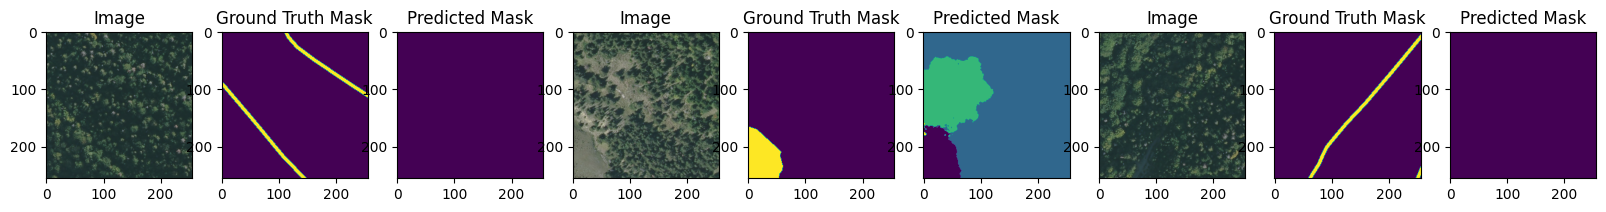

240/240 [==============================] - 180s 718ms/step - loss: 0.5039 - accuracy: 0.8178 - val_loss: 0.4288 - val_accuracy: 0.8565 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 2/15
1/1 [==============================] - 0s 27ms/step


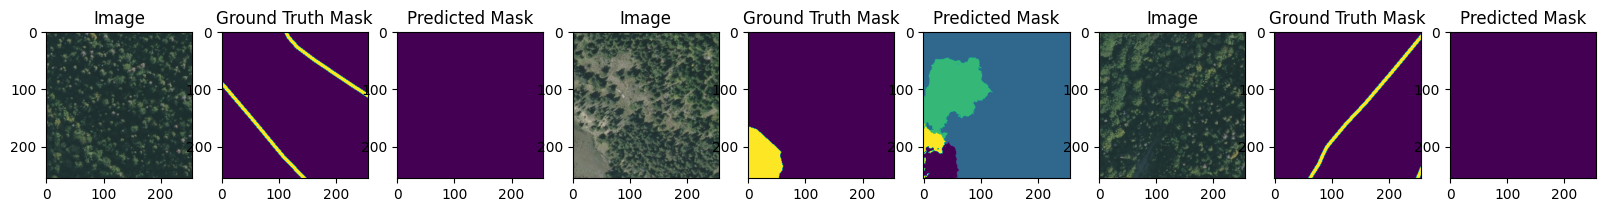

240/240 [==============================] - 175s 731ms/step - loss: 0.4911 - accuracy: 0.8213 - val_loss: 0.4403 - val_accuracy: 0.8482 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 3/15
1/1 [==============================] - 0s 26ms/step


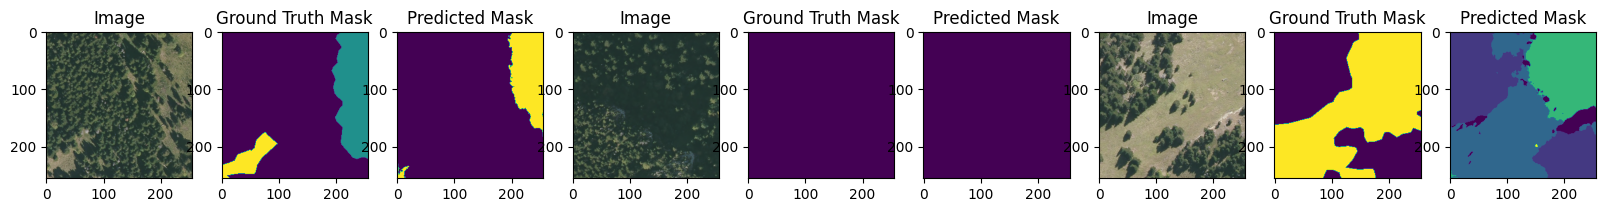

240/240 [==============================] - 176s 734ms/step - loss: 0.4824 - accuracy: 0.8247 - val_loss: 0.4628 - val_accuracy: 0.8403 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 4/15
1/1 [==============================] - 0s 23ms/step


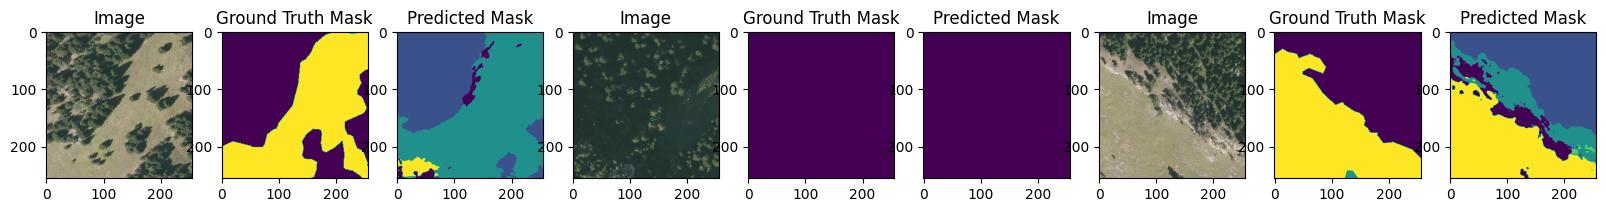

240/240 [==============================] - 176s 732ms/step - loss: 0.4799 - accuracy: 0.8254 - val_loss: 0.4079 - val_accuracy: 0.8587 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 5/15
1/1 [==============================] - 0s 22ms/step


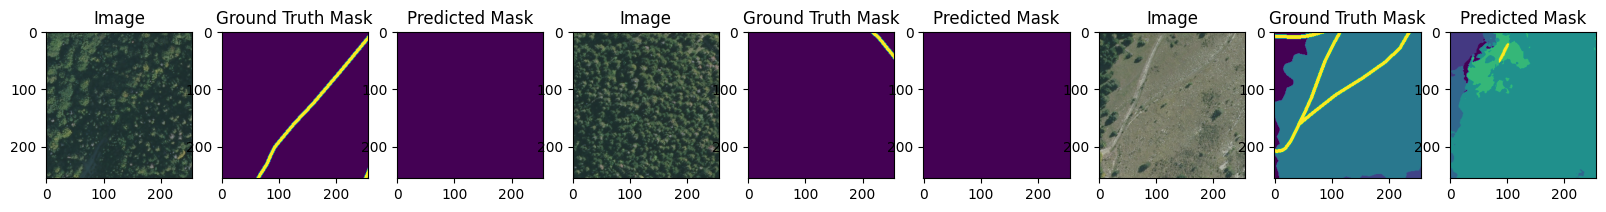

240/240 [==============================] - 175s 731ms/step - loss: 0.4766 - accuracy: 0.8259 - val_loss: 0.4496 - val_accuracy: 0.8438 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 6/15
1/1 [==============================] - 0s 21ms/step


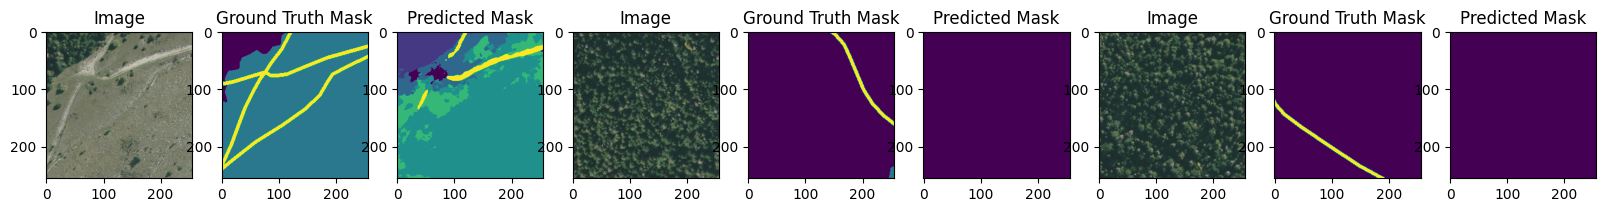

240/240 [==============================] - 176s 732ms/step - loss: 0.4738 - accuracy: 0.8274 - val_loss: 0.4993 - val_accuracy: 0.8232 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 7/15
1/1 [==============================] - 0s 25ms/step


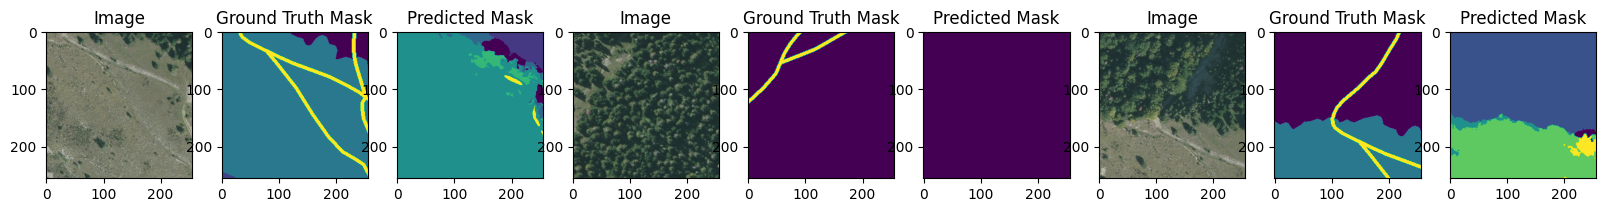

240/240 [==============================] - 176s 734ms/step - loss: 0.4866 - accuracy: 0.8221 - val_loss: 0.4621 - val_accuracy: 0.8365 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 8/15
1/1 [==============================] - 0s 23ms/step


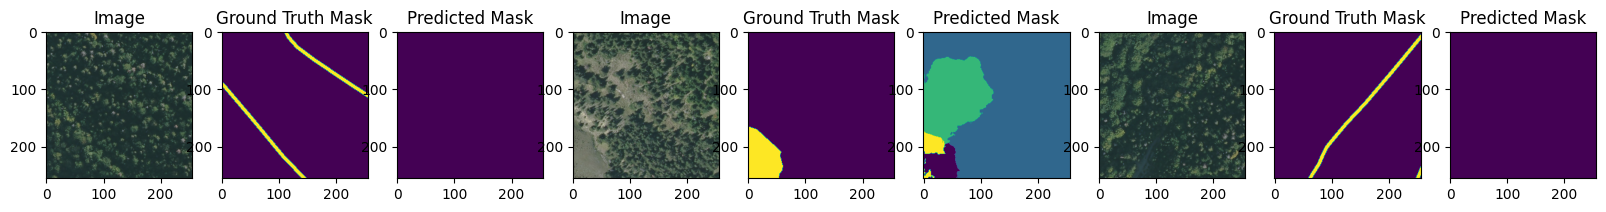


Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
240/240 [==============================] - 176s 732ms/step - loss: 0.4708 - accuracy: 0.8283 - val_loss: 0.4450 - val_accuracy: 0.8442 - lr: 1.0000e-04

Train_augm: Images augmented
Epoch 9/15
1/1 [==============================] - 0s 23ms/step


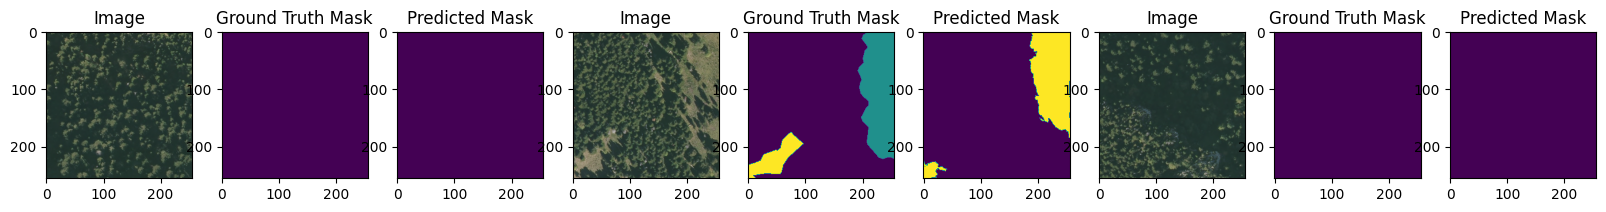

240/240 [==============================] - 175s 730ms/step - loss: 0.4721 - accuracy: 0.8277 - val_loss: 0.4701 - val_accuracy: 0.8335 - lr: 1.0000e-05

Train_augm: Images augmented
Epoch 10/15
1/1 [==============================] - 0s 22ms/step


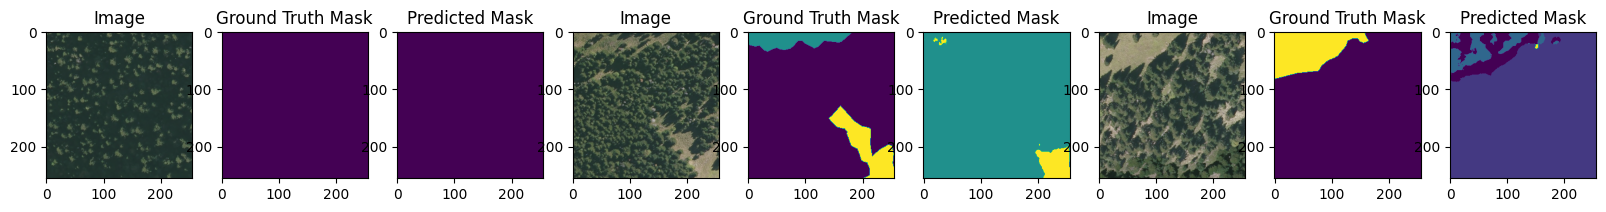

240/240 [==============================] - 176s 733ms/step - loss: 0.4630 - accuracy: 0.8310 - val_loss: 0.4964 - val_accuracy: 0.8299 - lr: 1.0000e-05

Train_augm: Images augmented
Epoch 11/15
1/1 [==============================] - 0s 21ms/step


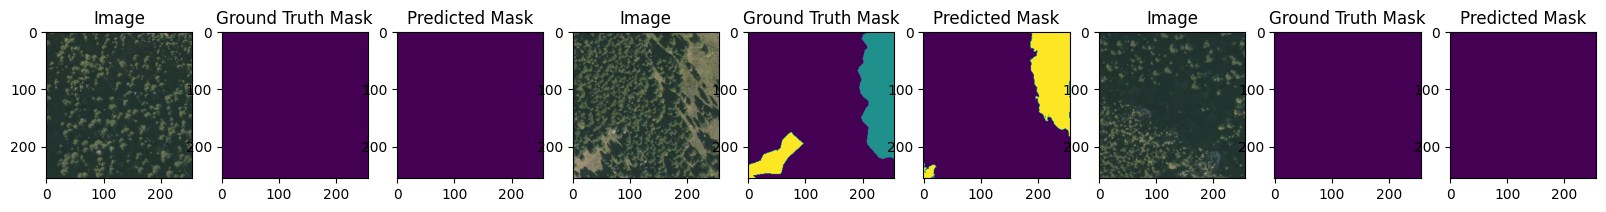

240/240 [==============================] - 176s 733ms/step - loss: 0.4694 - accuracy: 0.8283 - val_loss: 0.4492 - val_accuracy: 0.8420 - lr: 1.0000e-05

Train_augm: Images augmented
Epoch 12/15
1/1 [==============================] - 0s 22ms/step


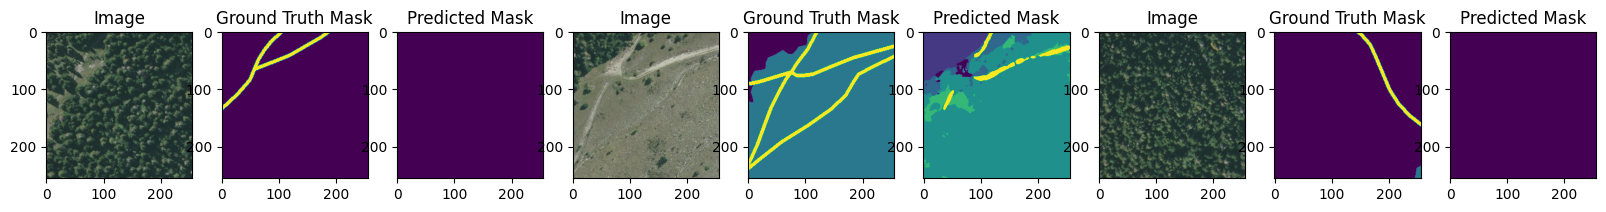


Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
240/240 [==============================] - 176s 735ms/step - loss: 0.4610 - accuracy: 0.8324 - val_loss: 0.4608 - val_accuracy: 0.8335 - lr: 1.0000e-05

Train_augm: Images augmented
Epoch 13/15
1/1 [==============================] - 0s 26ms/step


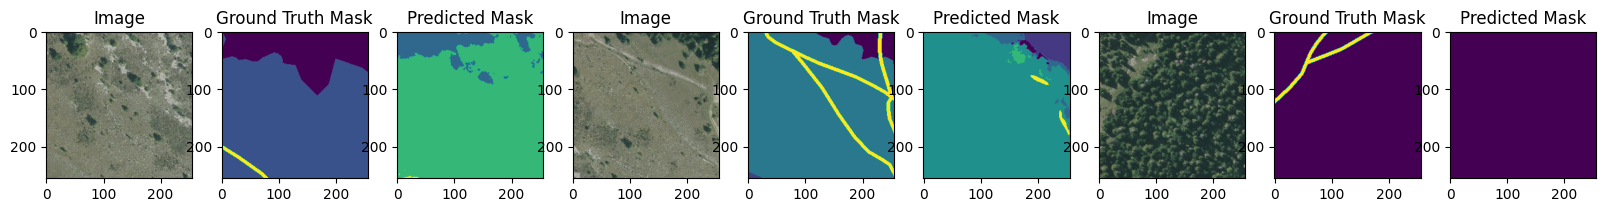

240/240 [==============================] - 192s 803ms/step - loss: 0.4733 - accuracy: 0.8270 - val_loss: 0.5164 - val_accuracy: 0.8141 - lr: 1.0000e-06

Train_augm: Images augmented
Epoch 14/15
1/1 [==============================] - 0s 29ms/step


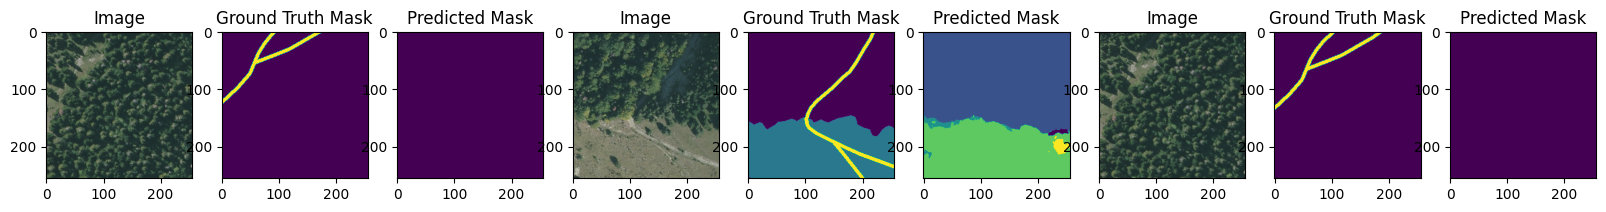

240/240 [==============================] - 176s 734ms/step - loss: 0.4713 - accuracy: 0.8278 - val_loss: 0.5042 - val_accuracy: 0.8259 - lr: 1.0000e-06

Train_augm: Images augmented
Epoch 15/15
1/1 [==============================] - 0s 27ms/step


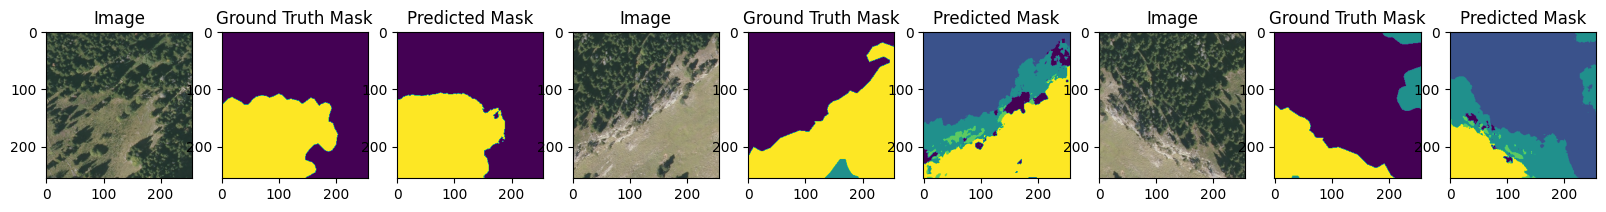

240/240 [==============================] - 176s 733ms/step - loss: 0.4722 - accuracy: 0.8278 - val_loss: 0.4816 - val_accuracy: 0.8335 - lr: 1.0000e-06


In [30]:
weight_dir=f"./model_weights/fine_tuning"
save_path=os.path.join(weight_dir,"256x256.weights_")

EPOCHS=15

history = net.fit(
    x=train_augm,
    epochs=EPOCHS,
    validation_data=val_augm,
    callbacks=callbacks
)

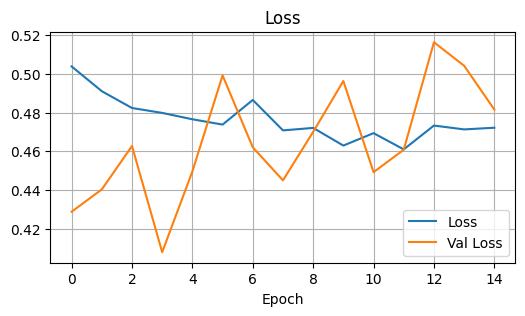

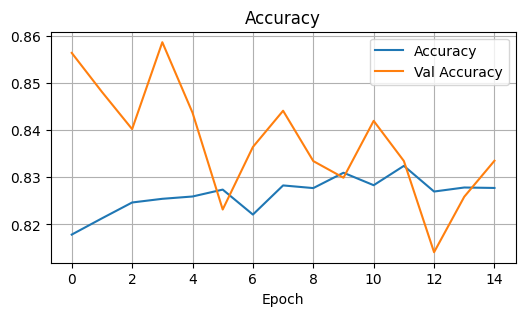

In [31]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(6,3))
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

The fact that the validation loss is lower and it's accuracy is better, is (probably) due to the Augmenter. Since that before each epoch the training images change, the model can't overfit on them, but the validation set is static and shows the true performance of the model.

## Final DICE

Once again, let'inspect the DICE score:

In [16]:
x_test_img,y_test_img=read_test_dataset(test_name,X_path,Y_path,SUBS) # load them again, they were deleted to save up some memory
evaluate_model(net,x_test_img,y_test_img,BATCH_SIZE,NUM_CLASSES,dice_coef_multilabel)

Processed 100 test images.
Processed 200 test images.
Total test images processed: 200.
total images on the test set: 3200
Batch 10/100 score: 0.61859
Running average: 0.7198287228616513
Batch 20/100 score: 0.80143
Running average: 0.699454274790399
Batch 30/100 score: 0.71846
Running average: 0.7163052991467966
Batch 40/100 score: 0.79877
Running average: 0.7200540649678319
Batch 50/100 score: 0.79493
Running average: 0.7156317690109338
Batch 60/100 score: 0.71069
Running average: 0.7144473156079274
Batch 70/100 score: 0.69253
Running average: 0.7114561281179445
Batch 80/100 score: 0.66231
Running average: 0.7094759849588415
Batch 90/100 score: 0.70380
Running average: 0.7069449975466177
Batch 100/100 score: 0.56982
Running average: 0.7065697956674021
Final test set score: 0.70657
